In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


### 1. Instructions:

In order to run the code properly, please follow this recommended procedure:

1)	Click on "Cell" and then click on "Run All".

2)	Select 'Test Type' parameter (i.e., Cyclic or Monotonic). The Available Test Cases corresponding to this Test Type will be shown on the DropDown Manu below. The description details of these available test cases will be shown in the text area to the right of the test case selection area. 

3) Select 'Stage' parameter (i.e., Consolidation or Shear). 

4) Select 'Test Case(s)' and start plotting. Click on a particular test case (e.g., 'SW1') to start plotting. To plot **multiple** Test Cases simultaneously, strike **'Ctrl'** key (or **'Command'** key for Mac) and hold, then start selecting multiple test cases. As one add or drop test cases, the plot area will be dynamically updated. 

5) Finally, one can export the produced figures into PDF. The file name needs to be specified by the user by typing in the 'Fig. Name' text box and end the name with '.pdf'. 

Note: DSS = 'Direct Simple Shear'

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
%matplotlib notebook
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import numpy as np
import pandas as pd
from ipywidgets import *
from IPython.display import display
from IPython.display import clear_output
from matplotlib import rc
from matplotlib import ticker
from scipy.signal import find_peaks_cwt
from scipy import optimize
from scipy.optimize import leastsq
import statsmodels.api as sm
import os

font = {'color':  'black',
        'weight': 'normal',
        'size': 11,
        }

layout100 = Layout(display='flex',flex_flow='row', border='solid 1px',align_items='stretch',width='100%')
matplotlib.rcParams.update({'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

/Users/annzhong/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
# Init Widget Elements 
radio_btn_test_type = widgets.RadioButtons(options=['Cyclic','Monotonic'],
                             description='DSS Test Type',variable=[True,False])

radio_btn_stage = widgets.RadioButtons(options=['Consolidation','Shear'],
                             description='Stage',variable=[True,False])


seclect_multi_test = widgets.SelectMultiple(
description="Test Cases",
options= []
)

ta = Textarea(value= "", disabled=True,
              layout=layout100,
              description="Details of Test Cases")

btn_save_figure = widgets.Button(description='Save All as PDF')
text_fig_name = widgets.Text(description="File Name")


slider_param = FloatSlider(min=1, max=20, step=0.5, description = "Strain% Adjustor", 
                              continuous_update = False)
slider_param.value = 3

In [5]:
###### Init input parameters #########
# All params defined here are global variables and are assumed to be visible throughout the notebook 
file_description = 'Description.csv'
#############################################################################################
info = pd.read_csv(file_description,delimiter=',',dtype='str',skiprows=13)
info = info.set_index('HEADING')
dssg = info.loc[:'GROUP']
dsst = info.loc['HEADING':]
dsst_col = dsst.loc['HEADING'].tolist()
dsst.columns = dsst_col
dsst = dsst[1:]
#############################################################################################

dir_root = os.getcwd()
dir_root_cyclic = dir_root + "/Cyclic/"
dir_root_monotonic = dir_root + "/Monotonic/"
test_dir = dir_root_monotonic

In [6]:
def on_button_save_fig_clicked(b):
    '''
    callback function for Saving Output Figures
    '''
    pdf = matplotlib.backends.backend_pdf.PdfPages(text_fig_name.value)
    
    if radio_btn_stage.value == "Consolidation":
        pdf.savefig(b.fig_consol)
    elif radio_btn_stage.value == "Shear": 
        pdf.savefig(b.fig_shear1)
        pdf.savefig(b.fig_shear2)
        pdf.savefig(b.fig_shear3)
        
    pdf.close()
    print('PDF Exported')
# add action to be performed on click
btn_save_figure.on_click(on_button_save_fig_clicked)


def get_test_dir(test_type):
    '''
    Get test dir according to chosen test type
    '''
    if test_type == "Cyclic":
        test_dir = dir_root_cyclic
    elif test_type == "Monotonic":
        test_dir = dir_root_monotonic  
    return test_dir

In [7]:
def get_descriptions(dssg, test, test_type):
    '''
    Create description string based on chosen test cases and test types
    
    Input Parameters:
    test: a list of test cases strings (e.g., ["FW1", "FW2"])
    test_type: Monotonic or Cyclic
    
    Current fescription format for each test case is: 
    SW3: Salt water mix of 90% silt and 10% bentonite clay
    
    
    dependency: require 'dssg'
    '''
    
    if test_type == "Cyclic":
        descriptions = ""
    elif test_type == "Monotonic":
        descriptions = ""
        for test_case in test: 
            this_row = dssg[dssg['SPEC_REF']==test_case]

            if len(this_row) != 0:
                new_description_to_append =  test_case + ": " + \
                    str(this_row["DSSG_DESC"].values[0]) + "\n"
            else:
                new_description_to_append = test_case + ": None" + "\n"
            descriptions = descriptions + new_description_to_append            
    return descriptions

############# get detailed descriptions ##################################
def describe(test_type, test_name, description_g, description_t, IVRt):
    if (description_t['DSST_IVS'].tolist() == []):
        print("None")
        return 

    if test_type != "Cyclic":
        print(test_name +' DESCRIPTION: \n'+ description_g['DSSG_DESC'].tolist()[0])
        print('And '+description_t['DSST_DESC'].tolist()[0])
        print('Plastic Limit(PL) = ' + description_g['DSSG_PL'].tolist()[0]+
            ';\nLiquid Limit(LL) = ' + description_g['DSSG_LL'].tolist()[0]+
            ';\nPlastic Index(PI) = ' + description_g['DSSG_PI'].tolist()[0]+
            ';\nMax. past pressure Sigma_p = '+ description_g['DSSG_SIGP'].tolist()[0]+'kPa;'
             )
        if IVRt == 0.9:
            print('Initial Void Ratio assumed to be 0.9;\n')
        else:
            print('\n')
    else:
        print('No description on test yet.\n')
 

In [8]:
import statsmodels.api as sm
def fit_csl(sigma_v, e_c, axes):
    '''
    x is in log(sigma_v)
    y is e_c
    fit a linear regression line
    
    y =  Gamma + Lambda * x
    '''
    # transform to log(sigma_v)
    logx = np.log(sigma_v)
    X = logx
    y = e_c #dependent variable
    
    # y = a  + b * x
    X = sm.add_constant(X)
    
    # construct a model, which is an ordinary least square model (OLS)
    model = sm.OLS(y,X)
    results = model.fit()   
    
    Gamma = results.params[0]
    Lambda = results.params[1]
    
    
    x_new = np.linspace(np.min(logx*0.8), np.max(logx*1.2),100)
    y_new = Gamma + Lambda * x_new
    #axes.semilogx(x_new, powerlaw(x_new, a, b))

    axes.plot(x_new, y_new)
    
    return (Gamma,Lambda, results.rsquared)

In [9]:
def fit_powerlaw(x, y, axes):
    '''
    Given x and y, this function solves for S and m.
    '''
    yerr = [i * 0.2 for i in y]
    logx = np.log10(x)
    logy = np.log10(y)

    yerr = np.asarray(yerr)
    y = np.asarray(y)
    x = np.asarray(x)
    logyerr = yerr / y

    fitfunc = lambda p, x: p[0] + p[1] * x
    errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err

    pinit = [1.0, -1.0]
    out = optimize.leastsq(errfunc, pinit,
                           args=(logx, logy, logyerr), full_output=1)

    pfinal = out[0]
    covar = out[1]
    b = pfinal[1]
    a = 10.0**pfinal[0]

    powerlaw = lambda x, a, b: a * (x**b)
    
    x_new = np.linspace(np.min(x*0.8), np.max(x*1.2),100)
    axes.semilogx(x_new, powerlaw(x_new, a, b))
    
    return (a,b)

In [10]:
def plot_CSR(time, shear_strain, ax, peak_avg, period, initial_vertical_stress,label_CSR):
    
    time_def_percent = time[-1]
    CSR = round(float(peak_avg/initial_vertical_stress),4)
    Number_of_Cycle = round(float(time_def_percent/period),1)    
                
    ax.semilogx(Number_of_Cycle, CSR, 'o', label = label_CSR)
    ax.set_xlabel('Number of Cycle, N (logscale)', fontdict=font)
    ax.set_ylabel('Cyclic Stress Ratio, CSR', fontdict=font)
    ax.set_title('Fig1: CSR Plot', fontdict=font)
    ax.grid(True, which='both')
    ax.tick_params(axis='x', which='minor')
    ax.legend(bbox_to_anchor=(1, 1),prop={'size':8}) 
    
    print (label_CSR + '; CSR ='+ str(CSR) + '; Number of Cycle: '+str(Number_of_Cycle))
    return (Number_of_Cycle, CSR)

In [11]:
def strength_normalize(OCR, initial_vertical_stress, shear_strain, shear_stress, ax, strain_limit):

    diff_arr = abs(abs(shear_strain) - strain_limit)
    index_min = diff_arr.argmin()
    residual = shear_stress[index_min]
    Su_sigma = residual/initial_vertical_stress

    ax.semilogx(OCR,Su_sigma,'o')
    ax.set_xlim([1, 10])
    ax.set_title('Strength Normalization Plot')
    ax.set_ylabel(r'$\mathrm{\frac{S_u}{\sigma_v}}$',fontsize=18)
    ax.set_xlabel('OCR')
    ax.tick_params(axis='y', which='minor')
    ax.grid(True, which="both")
    return(OCR,Su_sigma)
  

In [12]:
def plot_all(stage, test_type, seclect_multi_test):
     
    test_chose = list(seclect_multi_test)
    test_dir = get_test_dir(test_type)
    L = len(test_chose)
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-1,1))
    
    # for plotting later 
    Number_of_Cycle_arr = np.zeros(L)*np.nan 
    CSR_arr = np.zeros(L)*np.nan
    Void_Ratio_arrf = np.zeros(L)*np.nan
    Vertical_stress_arrf = np.zeros(L)*np.nan
    OCR_arr = np.zeros(L)*np.nan
    Su_arr = np.zeros(L)*np.nan
  
    ###----for consolidation----###
    if stage == 'Consolidation':
        if L > 0:
            f, axes = plt.subplots(1,3,figsize=(12,4),dpi=80)
            btn_save_figure.fig_consol = f
            
            for i in range(0,L):
                if test_type != 'Cyclic':
                    condition = ((dsst['SPEC_REF']==test_chose[i])&
                                (dsst['DSST_FSET']=='Consolidation.txt'))
                    description_t = dsst[condition]
                    description_g = dssg[(dssg['SPEC_REF']==test_chose[i])]
                    
                    if description_t['DSST_IVS'].tolist() == []:
                        IVSt = 0
                        FVSt = 0
                        IVRt = 0
                        FVRt = 0
                    else:
                        IVSt = float(description_t['DSST_IVS'].tolist()[0])
                        FVSt = float(description_t['DSST_FVS'].tolist()[0])
                        IVRt = float(description_t['DSST_IVR'].tolist()[0])
                        if IVRt == 0:
                            IVRt = 0.9
                        FVRt = float(description_t['DSST_FVR'].tolist()[0])
                    
                    describe(test_type=test_type, test_name=test_chose[i], 
                             description_g=description_g, description_t=description_t, 
                             IVRt=IVRt)
                else:
                    print('Medium Frequency')

                path = test_dir + test_chose[i]+'/'+ stage +'.txt'
                data = np.genfromtxt(path, delimiter=',', usecols=np.arange(0,21))                      

                time = data[2:, 0] - data[2,0]
                vertical_stress = data[2: ,18]
                pwp = data[2: ,20]
                axial_strain = data[2: ,15]
                shear_strain = data[2: ,14]
                
                if test_type != 'Cyclic':
                    axial_strain = pd.Series(data[2: ,15])
                    delta_e = (axial_strain/100)*(1+IVRt)
                    void_ratio = IVRt - delta_e
                    max_vstress = max(vertical_stress)
                    min_vstress = data[-1,18]
                    OCR = str(int(round(max_vstress/min_vstress)))
                    lab = test_chose[i] + '; ' + 'OCR='+OCR            
                else:
                    void_ratio = 0*time            
                    lab = test_chose[i] 
                
                axes[0].plot(time, vertical_stress, linewidth=1, label=lab);
                axes[0].set_xlabel('Time (s)',fontdict=font)
                axes[0].set_ylabel('Vertical Effective Stress (kPa)',fontdict=font)
                axes[0].xaxis.set_major_formatter(formatter) 
                axes[0].set_title('Fig1: Vertical Stress vs. Time', fontdict=font)
                axes[0].legend(bbox_to_anchor=(1,1),prop={'size':8})
                axes[0].grid(True)
                f.tight_layout()

                axes[1].plot(time, axial_strain, linewidth=1, label=lab);
                axes[1].set_xlabel('Time (s)', fontdict=font)
                axes[1].set_ylabel('Axial Strain (%)', fontdict=font)
                axes[1].xaxis.set_major_formatter(formatter)
                axes[1].set_title('Fig2: Axial Strain vs. Time', fontdict=font)
                axes[1].grid(True)
                axes[1].legend(bbox_to_anchor=(1,1),prop={'size':8})
                f.tight_layout()

                if test_type != 'Cyclic':
                    
                    axes[2].semilogx(IVSt, IVRt, 'o',label=test_chose[i]+'initial')
                    axes[2].semilogx(FVSt, FVRt, '^',label=test_chose[i]+'final')
                    axes[2].set_xlabel('Vertical Effective Stress (kPa)', fontdict=font)
                    axes[2].set_ylabel('Void Ratio', fontdict=font)
                    axes[2].set_title('Fig3: Void Ratio vs Vertical Stress', fontdict=font)
                    axes[2].grid(True, which='both')
                    axes[2].legend(bbox_to_anchor=(1,1),prop={'size':8})
                    f.tight_layout()

                    pd.options.display.max_colwidth = 100
                                      
                else:
                    axes[2].semilogx()
                    axes[2].set_xlabel('Vertical Effective Stress (kPa)', fontdict=font)
                    axes[2].set_ylabel('Void Ratio', fontdict=font)
                    axes[2].set_title('Fig3: NO DATA', fontdict=font)
                    axes[2].legend(bbox_to_anchor=(1,1),prop={'size':8})
                    axes[2].grid(True)
                    f.tight_layout()
                    print('No description on test yet.')
            
    
    ###----for shear test----###        
    elif stage == 'Shear':
        if L > 0:
            f1, axes1 = plt.subplots(1,3,figsize=(12,4),dpi=80)
            f2, axes2 = plt.subplots(2,2,figsize=(8,8),dpi=80)
            f3, axes3 = plt.subplots(1,1,figsize=(5,5),dpi=80)
            
            btn_save_figure.fig_shear1 = f1
            btn_save_figure.fig_shear2 = f2
            btn_save_figure.fig_shear3 = f3
            
            for i in range(0,L):
                path = test_dir + test_chose[i]+'/'+ stage +'.txt'
                data = np.genfromtxt(path, delimiter=',')

                time_raw = data[2: ,0] - data[2,0]
                shear_stress = data[2: ,17]
                shear_strain = data[2: ,14]
                
                strain_limit = slider_param.value
                is_abs_above_limit = abs(shear_strain) > strain_limit
                index_limit2 = np.where(is_abs_above_limit)[0][0] 
                index_min2 = index_limit2+1
                
                if test_type == 'Cyclic':
                    lab = test_chose[i]
                    driving = data[2: ,22]
                    start_index = np.where(driving>0)[0][0]
                    driving = driving[start_index:index_min2]
                    
                    pwp = data[start_index:index_min2,20]
                    vertical_stress = data[start_index:index_min2,18]
                    initial_vertical_stress = vertical_stress[0]
                    Ru = pwp/initial_vertical_stress
                    void_ratio = 0*time_raw
                    
                    time = time_raw[start_index:index_min2]-time_raw[start_index]
                    shear_strain = shear_strain[start_index:index_min2]
                    shear_stress = shear_stress[start_index:index_min2]
                    
                    for n in range(1,len(driving)):
                        if (driving[n]>driving[n-1]) & (driving[n]>driving[n+1]):
                            first_peak=n
                            peak1=shear_stress[first_peak]
                            peak2=shear_stress[first_peak*3]
                            period = (time[n+1])*4
                            break
                    peak_avg =(abs(peak1)+abs(peak2))/2
                    cycle_all = time/period
                    
                    axes2[1,0].plot(cycle_all, shear_strain, linewidth=1, label=lab)
                    axes2[1,0].set_xlabel('Number of Cycles, N', fontdict=font)
                    axes2[1,0].set_ylabel('Shear Strain (%)', fontdict=font)
                    axes2[1,0].set_title('Fig3: Shear Strain vs. N', fontdict=font)
                    #axes2[1,0].legend(bbox_to_anchor=(1, 1),prop={'size':8})
                    axes2[1,0].grid(True)
                    f2.tight_layout() 
                    
                    axes2[1,1].plot(cycle_all, Ru, linewidth=1, label=lab);
                    axes2[1,1].set_xlabel('Number of Cycles, N', fontdict=font)
                    axes2[1,1].set_ylabel('Normalized pwp, Ru', fontdict=font)
                    axes2[1,1].set_title('Fig4: Ru vs. N', fontdict=font)
                    axes2[1,1].grid(True)
                    f2.tight_layout() 
                    
                    lab_csr = lab +'; strain:'+ str(slider_param.value)+'%'
                    (Number_of_Cycle, CSR) = plot_CSR(time, shear_strain,axes3, peak_avg, 
                                                      period,initial_vertical_stress, lab_csr)
                    f3.tight_layout()
                    Number_of_Cycle_arr[i] =Number_of_Cycle
                    CSR_arr[i] =CSR
                    

                else:
                    max_strain = max(shear_strain)
                    diff_arr3 = abs(abs(shear_strain) - max_strain)
                    index_min3 = diff_arr3.argmin()
                    
                    shear_strain = data[2:index_min3,14]
                    time = data[2:index_min3,0] - data[2,0]
                    pwp = data[2:index_min3,20]
                    shear_stress = data[2:index_min3,17]
                    vertical_stress = data[2:index_min3,18]
                    FVSt = vertical_stress[-1]
                    
                    initial_vertical_stress = vertical_stress[0] 
                    condition = (dsst['SPEC_REF']==test_chose[i])&(dsst['DSST_FSET']=='Shear.txt')
                    description_g = dssg[(dssg['SPEC_REF']==test_chose[i])]
                    description_t = dsst[condition]
                    #initial and final void ratio:
                    IVRt = float(description_t['DSST_IVR'].tolist()[0])
                    FVRt = float(description_t['DSST_FVR'].tolist()[0])
                    OCR = str(int(description_t['DSST_IOCR'].tolist()[0]))        
                    lab = test_chose[i] + ';OCR='+OCR
                    
                    describe(test_type=test_type, test_name=test_chose[i], 
                             description_g=description_g, description_t=description_t, 
                             IVRt=IVRt)
                    
                    Void_Ratio_arrf[i] = FVRt
                    Vertical_stress_arrf[i] = FVSt
                    axes2[1,0].plot(np.log(FVSt), FVRt, '^',label=test_chose[i]+'final')
                    axes2[1,0].set_ylim([0.7,0.85])
                    axes2[1,0].set_xlabel('Log_Vertical Stress (kPa)', fontdict=font)
                    axes2[1,0].set_ylabel('Void Ratio', fontdict=font)
                    axes2[1,0].set_title('Fig3: Void Ratio vs. Log_Vertical Stress', fontdict=font)
                    axes2[1,0].legend(bbox_to_anchor=(1, 1),prop={'size':8})
                    axes2[1,0].grid(True)
                    f2.tight_layout()
                    
                    axes2[1,1].plot(shear_strain, pwp, linewidth=1, label=lab)
                    axes2[1,1].set_xlim([0,20])
                    axes2[1,1].set_xlabel('Shear Strain (%)', fontdict=font)
                    axes2[1,1].set_ylabel('Equiv. Pore Water Pressure (kPa)', fontdict=font)
                    axes2[1,1].set_title('Fig4: Pore Water Pressure vs. Time', fontdict=font)
                    #axes2[1,1].legend(bbox_to_anchor=(1, 1),prop={'size':8})
                    axes2[1,1].grid(True)
                    f2.tight_layout() 

                    (OCR, Su_sigma) = strength_normalize(OCR, initial_vertical_stress, shear_strain, shear_stress, 
                                                         axes3, strain_limit)
                    f3.tight_layout()
                    OCR_arr[i] =OCR
                    Su_arr[i] =Su_sigma
                    
                    pd.options.display.max_colwidth = 100
                    
                axes1[0].plot(time, shear_stress, linewidth=1, label=lab)
                #axes1[0].plot(time, driving, '--', color = '0.75')
                axes1[0].set_xlabel('Time (s)', fontdict=font)
                axes1[0].set_ylabel('Shear Stress (kPa)', fontdict=font)
                axes1[0].set_title('Fig1: Shear Stress vs. Time', fontdict=font)
                axes1[0].xaxis.set_major_formatter(formatter)
                #axes1[0].legend(bbox_to_anchor=(1, 1),prop={'size':8})
                axes1[0].grid(True)
                f1.tight_layout()

                axes1[1].plot(time, shear_strain, linewidth=1, label=lab);
                axes1[1].set_xlabel('Time (s)', fontdict=font)
                axes1[1].set_ylabel('Shear Strain (%)', fontdict=font)
                axes1[1].set_title('Fig2: Shear Strain vs. Time', fontdict=font)
                axes1[1].xaxis.set_major_formatter(formatter)
                #axes1[1].legend(bbox_to_anchor=(1, 1),prop={'size':8})
                axes1[1].grid(True)
                f1.tight_layout()

                axes1[2].plot(time, pwp, linewidth=1, label=lab);
                axes1[2].set_xlabel('Time (s)', fontdict=font)
                axes1[2].set_ylabel('Equiv. Pore Water Pressure (kPa)', fontdict=font)
                axes1[2].set_title('Fig3: Pore Water Pressure vs. Time', fontdict=font)
                axes1[2].legend(loc='lower right',prop={'size':8})
                axes1[2].xaxis.set_major_formatter(formatter)
                axes1[2].grid(True)
                f1.tight_layout()
                

                axes2[0,0].plot(vertical_stress, shear_stress, linewidth=1, label=lab);
                axes2[0,0].set_xlabel('Vertical Effective Stress (kPa)', fontdict=font)
                axes2[0,0].set_ylabel('Shear Stress (kPa)', fontdict=font)
                axes2[0,0].set_title('Fig1: Shear Stress vs. Vertical Effective Stress', fontdict=font)
                axes2[0,0].grid(True)
                f2.tight_layout()

                axes2[0,1].plot(shear_strain, shear_stress, linewidth=1, label=lab);
                if test_type != 'Cyclic':
                    axes2[0,1].set_xlim([0,20])
                    axes2[0,1].legend(loc='lower right',prop={'size':8})
                else:
                    axes2[0,1].legend(loc='upper left',prop={'size':8})
                axes2[0,1].set_xlabel('Shear Strain (%)', fontdict=font)
                axes2[0,1].set_ylabel('Shear stress (kPa)', fontdict=font)
                axes2[0,1].set_title('Fig2: Shear Stress vs. Shear Strain', fontdict=font) 
                axes2[0,1].grid(True)
                f2.tight_layout()
                
            #####################################
            if (stage == 'Shear')&(L>=2)&(test_type == 'Cyclic'):
                (a,b)=fit_powerlaw(Number_of_Cycle_arr, CSR_arr, axes3)
                a = round(float(a),3)
                b = round(float(b),3)
                axes3.text(2,0.15, r'${CRR = %.1f*N^{%.1f}}$' %(a,b),fontsize=12)
            
            if (stage == 'Shear')&(L>=2)&(test_type != 'Cyclic'):
                (gamma, labda, rsquared) = fit_csl(Vertical_stress_arrf, Void_Ratio_arrf, axes2[1,0])
                axes2[1,0].text(0.25,0.5,r'$CSL: e_c=%.2f%.2f*log(\sigma_v)$' %(gamma, labda),
                                fontsize=12,transform=axes2[1,0].transAxes)
                
                (S,m)=fit_powerlaw(OCR_arr, Su_arr, axes3)
                axes3.text(0.5,0.5,r'$\frac{S_u}{\sigma_v}=%4.2f * OCR^{%4.2f}$' %(S, m),fontsize=12, 
                             horizontalalignment='center',
                             verticalalignment='center',
                            transform=axes3.transAxes)

                f2.tight_layout()   
                

<IPython.core.display.Javascript object>


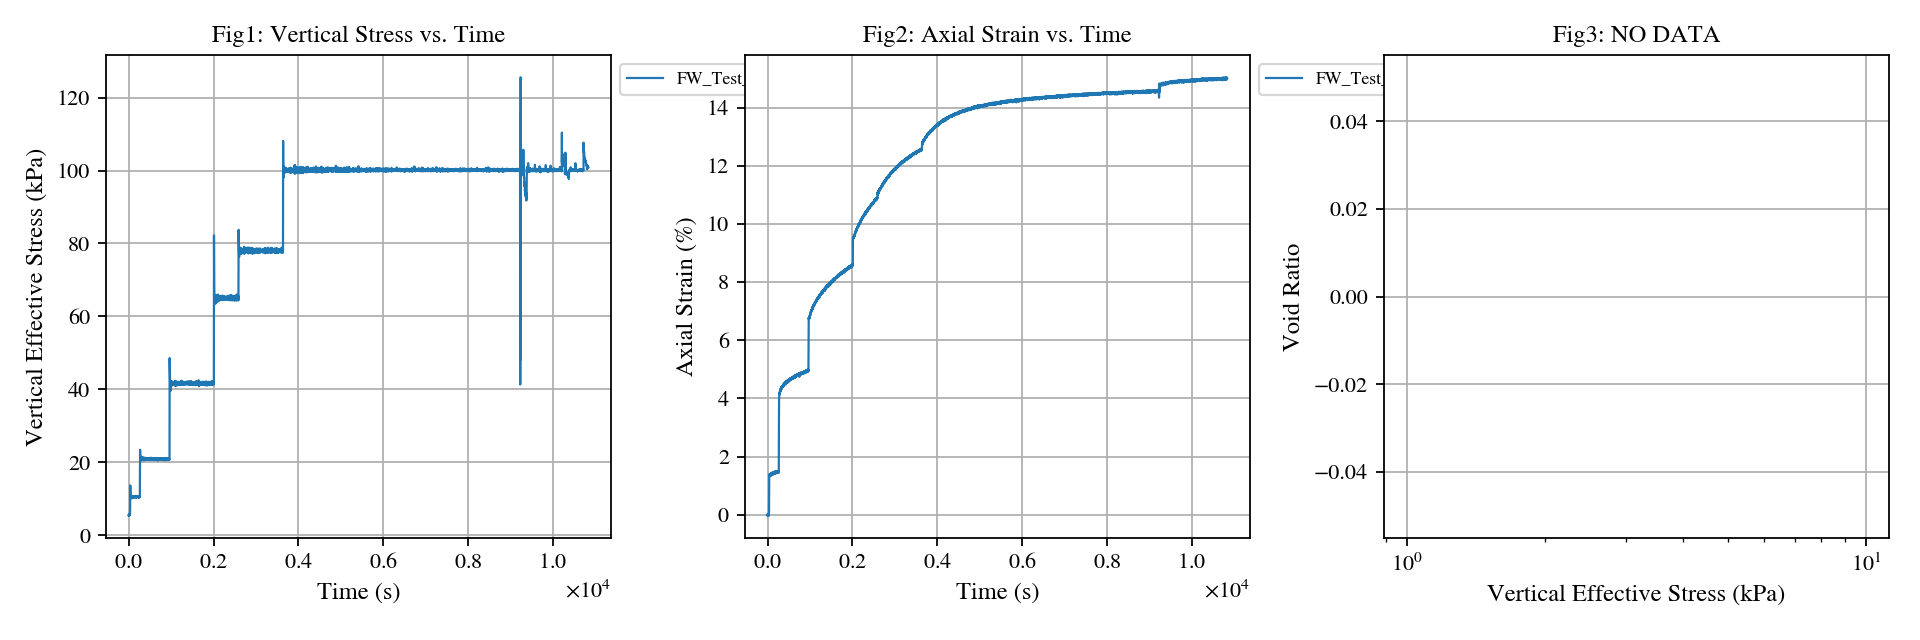

Medium Frequency
No description on test yet.


In [13]:
def on_test_type_change(*args):
    ##### Update Test Cases#####
    # Get all files in the current directory
    files = os.listdir(dir_root)
    test_type = radio_btn_test_type.value
    # get test dir per test type
    test_dir = get_test_dir(test_type)
        
    files = os.listdir(test_dir)
    test = [f for f in files if not f.startswith(".")]   
        
    seclect_multi_test.options = test
    
    ##### Update Text Area ########
    ta.value = get_descriptions(dssg = dssg, 
                                test = seclect_multi_test.options, test_type= radio_btn_test_type.value)
    
    
def update_plot(*args):
    clear_output()
    plt.close("all")
    plot_all(stage = radio_btn_stage.value, test_type = radio_btn_test_type.value, 
            seclect_multi_test = seclect_multi_test.value)
    
def on_slider_change(*args):
    if (radio_btn_stage.value == "Shear") & (radio_btn_test_type.value == "Cyclic"):        
        update_plot(*args)
    if (radio_btn_stage.value == "Shear") & (radio_btn_test_type.value == "Monotonic"):  
        update_plot(*args)

files = os.listdir(get_test_dir(radio_btn_test_type.value))
test = [f for f in files if not f.startswith(".")]

seclect_multi_test.options = test
# add test_type observer
radio_btn_test_type.observe(on_test_type_change, names="value")
seclect_multi_test.observe(update_plot, names="value")
radio_btn_stage.observe(update_plot, names="value")
# update plot when slider changes and filter is matched 
slider_param.observe(on_slider_change, names="value")

hbox_param_major = widgets.HBox([radio_btn_test_type, radio_btn_stage, slider_param], 
    layout = Layout(display='flex',flex_flow='row', border='solid 1px',align_items='stretch', width='100%',height="50%"))

vbox_test = widgets.VBox([seclect_multi_test], 
    layout = Layout(overflow_y = "scroll", display='flex',flex_flow='row', border='solid 1px',
                    align_items='stretch', width="50%")) 
hbox_main =widgets.HBox([vbox_test, ta],
    layout = Layout(display='flex',flex_flow='row',align_items='stretch', width='100%',height="70%"))

hbox_save_fig = widgets.HBox([text_fig_name, btn_save_figure],
          layout = Layout(display='flex',flex_flow='row', border='solid 1px',align_items='stretch', width='100%',height="30%"))                   

display(hbox_param_major)
display(hbox_main)
display(hbox_save_fig)

